In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA


# Load the datasets
TodaysData_Country = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')
cleaned_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')
owid_covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')


C:\Users\gesua\AppData\Local\Temp\ipykernel_47876\2070741813.py:12: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')


In [76]:
# Check the columns in the dataset
print(cleaned_data.columns)
print(cleaned_data.head)


Index(['index', 'Country_Region', 'Last_Update', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'Delta_Confirmed', 'Delta_Recovered',
       'Incident_Rate', 'People_Tested', 'People_Hospitalized',
       'Province_State', 'FIPS', 'UID', 'iso3', 'Report_Date_String',
       'Delta_Deaths'],
      dtype='object')
<bound method NDFrame.head of          index Country_Region Last_Update  Confirmed  Deaths  Recovered  \
0            0    Afghanistan     1/22/20          0       0        NaN   
1            1    Afghanistan     1/23/20          0       0        NaN   
2            2    Afghanistan     1/24/20          0       0        NaN   
3            3    Afghanistan     1/25/20          0       0        NaN   
4            4    Afghanistan     1/26/20          0       0        NaN   
...        ...            ...         ...        ...     ...        ...   
296032  296032             US      3/5/23     185159    2002        NaN   
296033  296033             US      3/6/23     1851

In [55]:
import pandas as pd

cleaned_data.reset_index(inplace=True)

us_data = cleaned_data[cleaned_data['Country_Region'] == 'US'].copy()
us_data['Last_Update'] = pd.to_datetime(us_data['Last_Update'], errors='coerce')
us_data = us_data.dropna(subset=['Last_Update', 'Confirmed'])
us_data = us_data.sort_values('Last_Update')
us_data.reset_index(inplace=True)

print(us_data.columns)


C:\Users\gesua\AppData\Local\Temp\ipykernel_47876\755664721.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_data['Last_Update'] = pd.to_datetime(us_data['Last_Update'], errors='coerce')


Index(['level_0', 'index', 'Country_Region', 'Last_Update', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'Delta_Confirmed', 'Delta_Recovered',
       'Incident_Rate', 'People_Tested', 'People_Hospitalized',
       'Province_State', 'FIPS', 'UID', 'iso3', 'Report_Date_String',
       'Delta_Deaths'],
      dtype='object')


In [56]:
# rolling mean
us_data = cleaned_data[cleaned_data['Country_Region'] == 'US']
us_data_numeric = us_data[['Confirmed', 'Deaths', 'Recovered', 'Active']].copy()
rolmean_us = us_data_numeric.rolling(window=3).mean()
print(rolmean_us.head())

        Confirmed  Deaths  Recovered  Active
212598        NaN     NaN        NaN     NaN
212599        NaN     NaN        NaN     NaN
212600   1.333333     0.0        NaN     NaN
212601   1.666667     0.0        NaN     NaN
212602   3.000000     0.0        NaN     NaN


In [57]:
#rolling std
us_data = cleaned_data[cleaned_data['Country_Region'] == 'US']
us_data_numeric = us_data[['Confirmed', 'Deaths', 'Recovered', 'Active']].copy()
rolstd_us = us_data_numeric.rolling(window=3).std()
print(rolstd_us.head())


        Confirmed  Deaths  Recovered  Active
212598        NaN     NaN        NaN     NaN
212599        NaN     NaN        NaN     NaN
212600   0.577350     0.0        NaN     NaN
212601   0.577350     0.0        NaN     NaN
212602   1.732051     0.0        NaN     NaN


C:\Users\gesua\AppData\Local\Temp\ipykernel_47876\2953845852.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_data['Last_Update'] = pd.to_datetime(us_data['Last_Update'], errors='coerce')


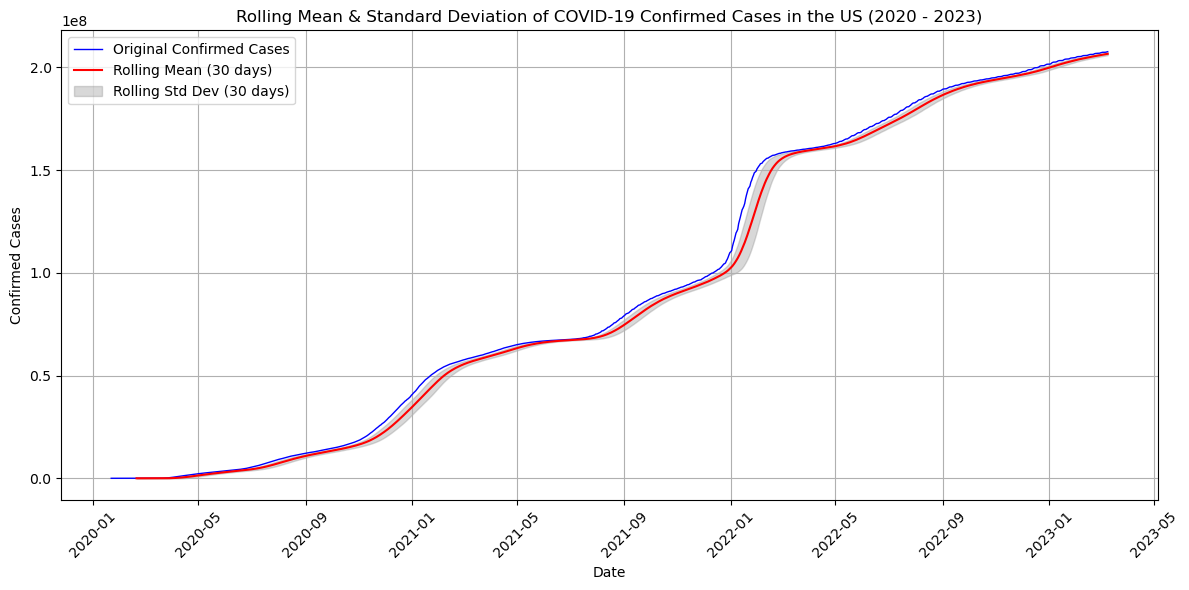

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

us_data = cleaned_data[cleaned_data['Country_Region'] == 'US'].copy()
us_data['Last_Update'] = pd.to_datetime(us_data['Last_Update'], errors='coerce')
us_data = us_data.dropna(subset=['Last_Update', 'Confirmed'])
us_data['Confirmed'] = pd.to_numeric(us_data['Confirmed'], errors='coerce')
us_data = us_data.groupby('Last_Update')['Confirmed'].sum().reset_index()
us_data = us_data.sort_values('Last_Update')
us_data.set_index('Last_Update', inplace=True)

rolling_mean_us = us_data['Confirmed'].rolling(window=30).mean()
rolling_std_us = us_data['Confirmed'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(us_data['Confirmed'], color='b', label='Original Confirmed Cases', linewidth=1)
plt.plot(rolling_mean_us, color='r', label='Rolling Mean (30 days)', linewidth=1.5)
plt.fill_between(us_data.index, rolling_mean_us - rolling_std_us, rolling_mean_us + rolling_std_us, color='gray', alpha=0.3, label='Rolling Std Dev (30 days)')

plt.title('Rolling Mean & Standard Deviation of COVID-19 Confirmed Cases in the US (2020 - 2023)')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [70]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')

# Perform Dickey-Fuller test on the 'Confirmed' column
dftest = adfuller(us_data['Confirmed'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

print(dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                   -0.033992
p-value                           0.955629
# Lags Used                      23.000000
Number of Observations Used    1119.000000
Critical Value (1%)              -3.436207
Critical Value (5%)              -2.864126
Critical Value (10%)             -2.568147
dtype: float64


C:\Users\gesua\AppData\Local\Temp\ipykernel_47876\2452699430.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  florida_data['Last_Update'] = pd.to_datetime(florida_data['Last_Update'], errors='coerce')


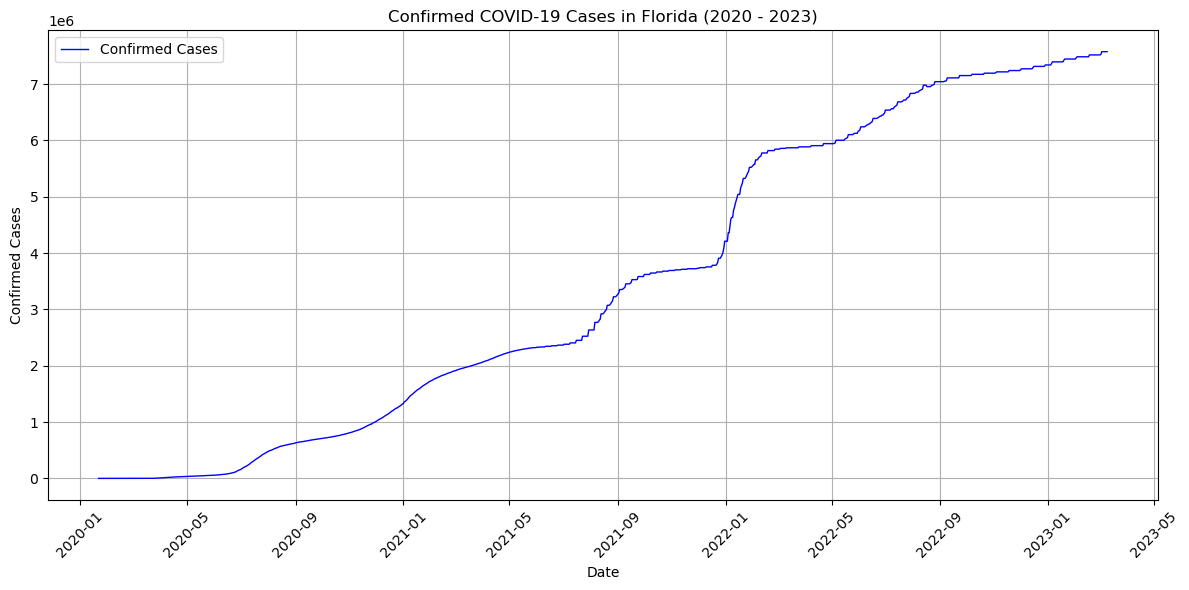

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

florida_data = cleaned_data[(cleaned_data['Country_Region'] == 'US') & (cleaned_data['Province_State'] == 'Florida')].copy()
florida_data['Last_Update'] = pd.to_datetime(florida_data['Last_Update'], errors='coerce')
florida_data = florida_data.dropna(subset=['Last_Update', 'Confirmed'])
florida_data['Confirmed'] = pd.to_numeric(florida_data['Confirmed'], errors='coerce')
florida_data = florida_data.groupby('Last_Update')['Confirmed'].sum().reset_index()
florida_data = florida_data.sort_values('Last_Update')
florida_data.set_index('Last_Update', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(florida_data['Confirmed'], color='b', label='Confirmed Cases', linewidth=1)

plt.title('Confirmed COVID-19 Cases in Florida (2020 - 2023)')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\gesua\AppData\Local\Temp\ipykernel_47876\3044543665.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fl_data['Last_Update'] = pd.to_datetime(fl_data['Last_Update'], errors='coerce')


Results of Augmented Dickey-Fuller Test:
Test Statistic                   -5.490152
p-value                           0.000002
# Lags Used                      23.000000
Number of Observations Used    1118.000000
Critical Value (1%)              -3.436213
Critical Value (5%)              -2.864129
Critical Value (10%)             -2.568148
dtype: float64


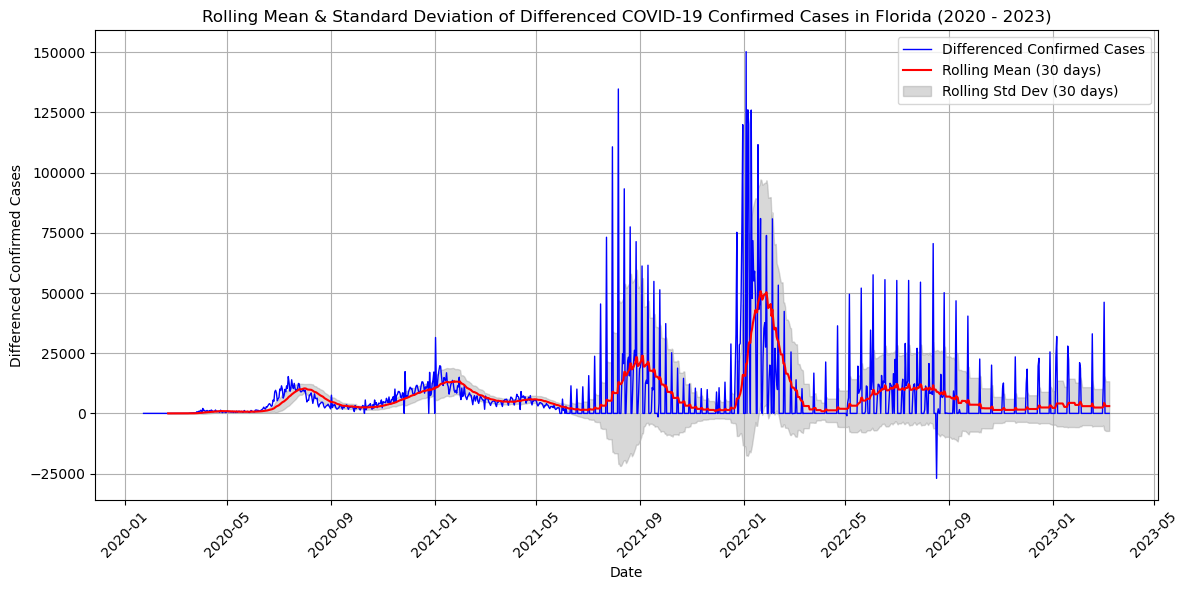

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

fl_data = cleaned_data[(cleaned_data['Country_Region'] == 'US') & (cleaned_data['Province_State'] == 'Florida')].copy()
fl_data['Last_Update'] = pd.to_datetime(fl_data['Last_Update'], errors='coerce')
fl_data = fl_data.dropna(subset=['Last_Update', 'Confirmed'])
fl_data['Confirmed'] = pd.to_numeric(fl_data['Confirmed'], errors='coerce')
fl_data = fl_data.groupby('Last_Update')['Confirmed'].sum().reset_index()
fl_data = fl_data.sort_values('Last_Update')
fl_data.set_index('Last_Update', inplace=True)
fl_data['Differenced_Confirmed'] = fl_data['Confirmed'].diff()
fl_data.dropna(subset=['Differenced_Confirmed'], inplace=True)

print('Results of Augmented Dickey-Fuller Test:')
adf_test = adfuller(fl_data['Differenced_Confirmed'])
adf_results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_results['Critical Value (%s)' % key] = value
print(adf_results)

rolling_mean_diff = fl_data['Differenced_Confirmed'].rolling(window=30).mean()
rolling_std_diff = fl_data['Differenced_Confirmed'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(fl_data['Differenced_Confirmed'], color='b', label='Differenced Confirmed Cases', linewidth=1)
plt.plot(rolling_mean_diff, color='r', label='Rolling Mean (30 days)', linewidth=1.5)
plt.fill_between(fl_data.index, rolling_mean_diff - rolling_std_diff, rolling_mean_diff + rolling_std_diff,
                 color='gray', alpha=0.3, label='Rolling Std Dev (30 days)')

plt.title('Rolling Mean & Standard Deviation of Differenced COVID-19 Confirmed Cases in Florida (2020 - 2023)')
plt.xlabel('Date')
plt.ylabel('Differenced Confirmed Cases')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [88]:
from statsmodels.tsa.stattools import arma_order_select_ic

# Perform lag selection using arma_order_select_ic
order_selection = arma_order_select_ic(fl_data['Differenced_Confirmed'].dropna(), ic='aic', max_ar=5, max_ma=5)

# Print the optimal AR and MA orders based on AIC
print("Optimal ARMA Orders based on AIC:")
print(order_selection.aic_min_order)


C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\base\model

Optimal ARMA Orders based on AIC:
(5, 5)


C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 SARIMAX Results                                 
Dep. Variable:     Differenced_Confirmed   No. Observations:                 1142
Model:                    ARIMA(5, 0, 5)   Log Likelihood              -12381.593
Date:                   Sun, 06 Oct 2024   AIC                          24787.186
Time:                           21:26:13   BIC                          24847.673
Sample:                       01-23-2020   HQIC                         24810.027
                            - 03-09-2023                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6632.7408   7.33e-10   9.05e+12      0.000    6632.741    6632.741
ar.L1          0.5560      0.035     15.990      0.000       0.488       0.624
ar.L2         -1.0448      0

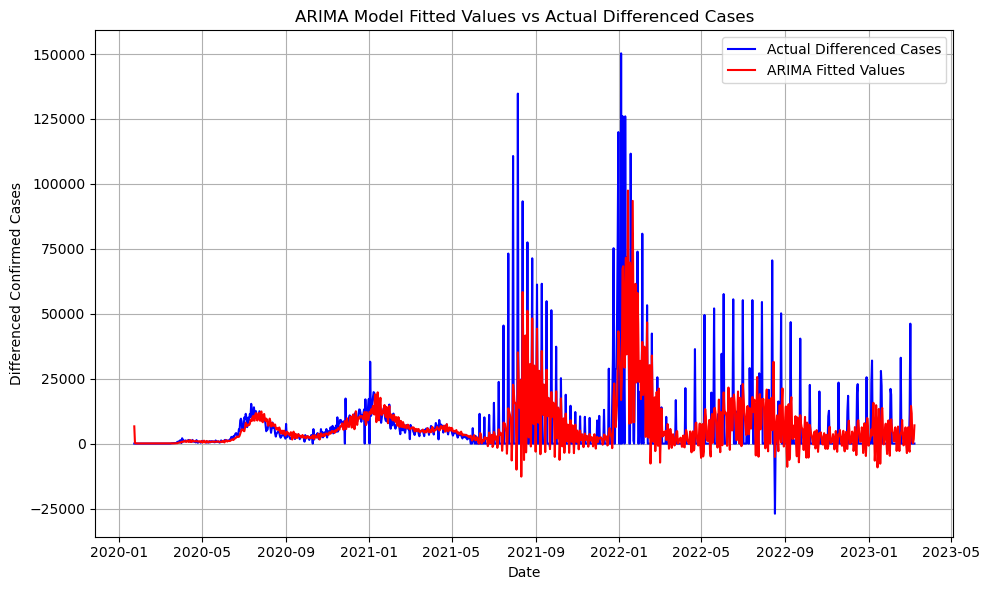

In [94]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(fl_data['Differenced_Confirmed'].dropna(), order=(5, 0, 5))
fit_arima = model.fit()

# Print the model summary
print(fit_arima.summary())

# Plotting the fitted values vs. actual differenced data
plt.figure(figsize=(10, 6))
plt.plot(fl_data['Differenced_Confirmed'].dropna(), label='Actual Differenced Cases', color='blue')
plt.plot(fit_arima.fittedvalues, label='ARIMA Fitted Values', color='red')
plt.title('ARIMA Model Fitted Values vs Actual Differenced Cases')
plt.xlabel('Date')
plt.ylabel('Differenced Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\gesua\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


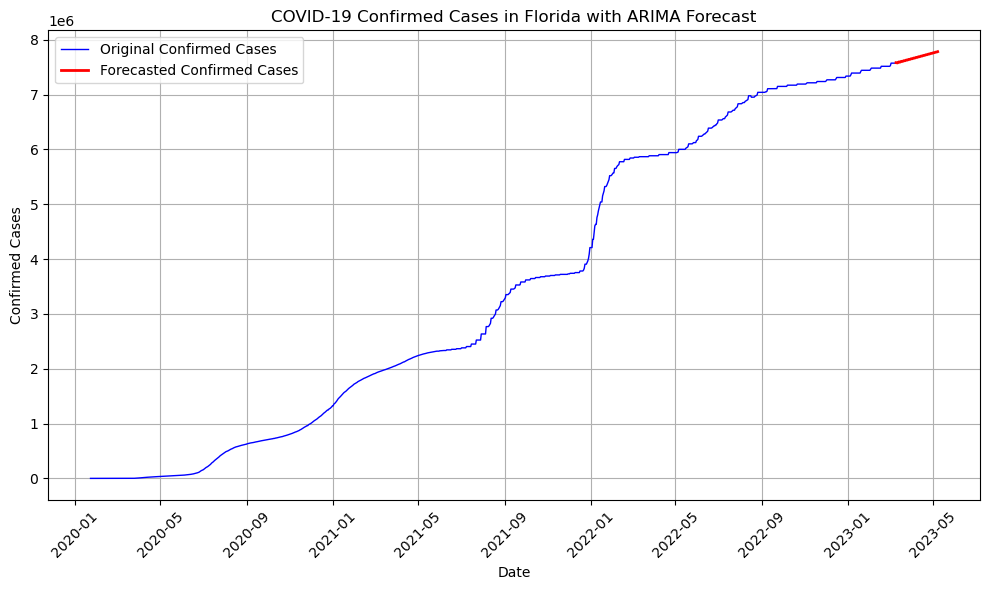

In [102]:
model = ARIMA(fl_data['Differenced_Confirmed'].dropna(), order=(5, 0, 5))
fit_arima = model.fit()

forecast_steps = 60
forecast = fit_arima.forecast(steps=forecast_steps)

last_observed = fl_data['Confirmed'].iloc[-1]
forecast_original_scale = forecast.cumsum() + last_observed

plt.figure(figsize=(10, 6))
plt.plot(fl_data.index, fl_data['Confirmed'], label='Original Confirmed Cases', color='blue', linewidth=1)

forecast_dates = pd.date_range(start=fl_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(forecast_dates, forecast_original_scale, label='Forecasted Confirmed Cases', color='red', linewidth=2)

plt.title('COVID-19 Confirmed Cases in Florida with ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
